<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-1">Objective</a></span></li><li><span><a href="#Train-valid-split" data-toc-modified-id="Train-valid-split-2">Train-valid-split</a></span></li><li><span><a href="#About-Food-101" data-toc-modified-id="About-Food-101-3">About Food-101</a></span></li><li><span><a href="#Load-Food-101-Dataset" data-toc-modified-id="Load-Food-101-Dataset-4">Load Food-101 Dataset</a></span></li><li><span><a href="#Baseline-Resnet-34-Model" data-toc-modified-id="Baseline-Resnet-34-Model-5">Baseline Resnet-34 Model</a></span><ul class="toc-item"><li><span><a href="#Finding-a-Good-Learning-Rate" data-toc-modified-id="Finding-a-Good-Learning-Rate-5.1">Finding a Good Learning Rate</a></span></li><li><span><a href="#Training-the-Head-Only" data-toc-modified-id="Training-the-Head-Only-5.2">Training the Head Only</a></span></li><li><span><a href="#Training-the-Entire-Network" data-toc-modified-id="Training-the-Entire-Network-5.3">Training the Entire Network</a></span></li><li><span><a href="#Test-Time-Augmentation" data-toc-modified-id="Test-Time-Augmentation-5.4">Test Time Augmentation</a></span></li></ul></li><li><span><a href="#First-Crack-at-a-Better-Model" data-toc-modified-id="First-Crack-at-a-Better-Model-6">First Crack at a Better Model</a></span><ul class="toc-item"><li><span><a href="#Progressive-Resizing" data-toc-modified-id="Progressive-Resizing-6.1">Progressive Resizing</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import torch

from pathlib import Path
from fastai2.vision.all import *

In [2]:
# Set seed for reproducibility
seed = 9
torch.manual_seed(seed)
np.random.seed(seed)

---------

# Objective

The goal of this notebook is to train an image classifier on the [Food-101 dataset](https://www.kaggle.com/dansbecker/food-101) using the `fastai2` library. Thanks to fastai's incredible set of transformations and augmentations, state-of-the-art on the Food-101 dataset is [~90% Top-1 accuracy](https://platform.ai/blog/page/3/new-food-101-sota-with-fastai-and-platform-ais-fast-augmentation-search/) as of 02/2019. We should be able to match this. Afterwards, we'll build our own classifier in base `pytorch` without using `fastai` to make sure we understand all of the key components.

--------

# Train-valid-split

We've split the `Food-101` dataset beforehand into Imagenet-style `train/` and `valid/` folders following the `train.txt` and `test.txt` files provided in the dataset's `meta/` directory. This makes loading the data easier as with fastai's `DataBlock` class.

--------

# About Food-101

The [`Food-101` dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) consists of 101 classes of food, with $750$ training images and $250$ validation images for each class, for a total of $75,750$ training images and $25,250$ validation images. Classes include foods like `apple pie, bibimbap, crab cakes, gyoza, nachos, and pho`.

All images have been rescaled to have a maximum side length of $512$ pixels and training images have been deliberately left uncleaned (mostly in the form of intense colours and occassionally incorrect labels, according to the authors of the [original paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)). Examining a few images from a handful of classes, we find that $512$ x $384$ (or the transpose) is a common image size.

------------

# Load Food-101 Dataset

Let's load and prep our data for modeling.

In [4]:
# Prep DataBlock with item & batch transforms
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                  get_items=get_image_files,
                  get_y=parent_label,
                  item_tfms=Resize(460),
                  batch_tfms=aug_transforms(size=224, min_scale=0.75))

# Load data
path = Path("../data/food-101")
dls = dblock.dataloaders(path, bs=64)

/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


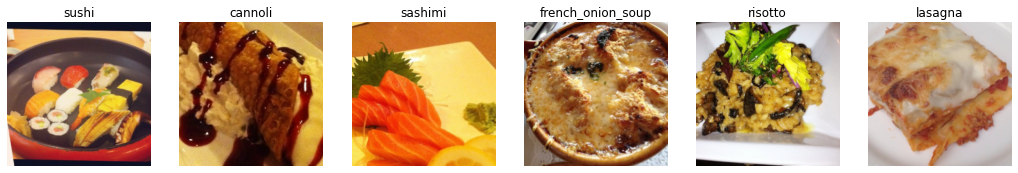

In [5]:
# Check data; yum! looks good!
dls.show_batch(nrows=1, ncols=6)

---------

# Baseline Resnet-34 Model

Let's start with `Resnet-34` and the default fastai `cnn_learner` parameters as our baseline model. We will

* Start by finding a good initial learning rate for training the head of the model
* Train for a few epochs with all layers frozen except for the head
* Unfreeze all layers and find a good learning rate range to use for all layers
* Train the entire unfrozen network with discriminative learning rates

We'll use `Top-1` and `Top-5` accuracy as our validation metrics throughout. 

Note that `cnn_learner` automatically normalizes its data using the stats of the pre-trained model (which will be `ImageNet` stats in our case).

## Finding a Good Learning Rate

Let's start by finding a good base learning rate.

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.010964781977236271)

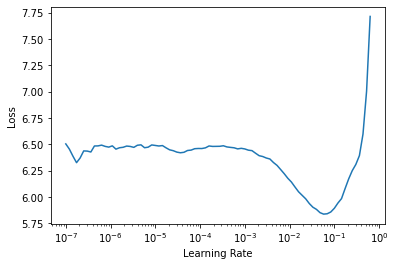

In [7]:
learn = cnn_learner(dls, resnet34)
learn.lr_find()

Looks like the steepest slope is `1e-2`. Let's choose that as our base learning rate and train the head  for a few epochs, keeping the other layers frozen.

## Training the Head Only

Now let's train the head of the network using the learning rate we found above.

In [9]:
# Re-initialize learner (since we trained it a bit to find a good lr)
learn = cnn_learner(dls, resnet34, metrics=[accuracy, top_k_accuracy])
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.165996,2.125329,0.462327,0.741931,14:20
1,1.684405,1.400663,0.632723,0.862426,14:18
2,1.466313,1.215823,0.683960,0.888812,14:18


In [10]:
# Let's save this initial model
learn.save("resnet34-head")

## Training the Entire Network

Now that we've trained the head for a few epochs, we're ready to unfreeze and train the entire network. But before we train we need to find a good range of learning rates to use. The lr plot will be different to the one above, since our model has been trained for a bit.

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.0892961401841603e-05)

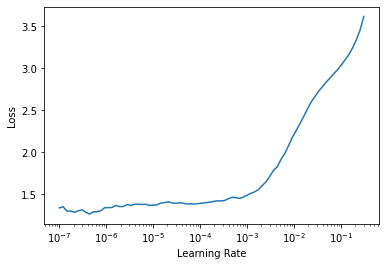

In [11]:
learn.unfreeze()
learn.lr_find()

We're looking for a range well before the loss sharply increases. Looks like `[1e-6, 1e-4]` will do. Now we're ready to train the entire unfrozen network.

In [ ]:
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.396312,1.213893,0.683465,0.888515,14:19
1,1.402325,1.212870,0.684059,0.889653,14:17


In [ ]:
# Let's save the final trained model
learn.save("resnet34-baseline")

## Test Time Augmentation

The last thing we can do to squeeze out a bit of performance is use test time augmentation. We'll use fastai's default `tta()` method, which averages a model's prediction with the predictions from 4 augmented images.

In [ ]:
preds, targets = learn.tta()
top_1 = accuracy(preds, targets).item()
top_5 = top_k_accuracy(preds, targets, k=5).item()
print(f"Top-1 Accuracy: {top_1: .4f} | Top-5 Accuracy {top_5: .4f}")

------------

# First Crack at a Better Model

Now that we have a solid baseline model, it's time to experiment and see if we can't do a little better! We'll experiment with

* Progressive resizing -- training first on small images and finishing on larger images
* Label Smoothing -- changing `(0, 1)` to something like `(0.1, 0.9)`
* Mixup -- taking a linear combination of images and labels, like `new_image = t * image + (1 - t) * random_image`

## Progressive Resizing 